In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from supabase import create_client
from dotenv import load_dotenv

sns.set_theme(style="whitegrid")


# 1️⃣ Connect to Supabase
 
load_dotenv()
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")

supabase = create_client(url, key)


# 2️⃣ Read Data From Supabase
response = supabase.table("churn_data").select("*").execute()
df = pd.DataFrame(response.data)

print("Rows Loaded:", len(df))
df.head()


Rows Loaded: 1000


,id,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,...,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,tenure_group,monthly_charge_segment,has_internet_service,is_multi_line_user,contract_type_code
0,1,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,Yes,Electronic check,29.85,29.85,No,New,Low,1,0,0
1,2,0,No,No,34,Yes,No,DSL,Yes,No,...,No,Mailed check,56.95,1889.50,No,Regular,Medium,1,0,1
2,3,0,No,No,2,Yes,No,DSL,Yes,Yes,...,Yes,Mailed check,53.85,108.15,Yes,New,Medium,1,0,0
3,4,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,Bank transfer (automatic),42.30,1840.75,No,Loyal,Medium,1,0,1
4,5,0,No,No,2,Yes,No,Fiber optic,No,No,...,Yes,Electronic check,70.70,151.65,Yes,New,High,1,0,0


In [2]:
# Standard imports
import os
import json
from pathlib import Path
import pandas as pd
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Try importing Supabase client (optional)
try:
    from supabase import create_client
    SUPABASE_AVAILABLE = True
except Exception:
    SUPABASE_AVAILABLE = False

def get_supabase_client():
    load_dotenv()
    if not SUPABASE_AVAILABLE:
        return None
    url = os.getenv('SUPABASE_URL')
    key = os.getenv('SUPABASE_KEY')
    if not url or not key:
        return None
    try:
        return create_client(url, key)
    except Exception as e:
        print('Could not create Supabase client:', e)
        return None

In [4]:
# Paths and outputs
HERE = Path('.').resolve()
STAGED_CSV = Path('data/staged/churn_staged.csv')
PROCESSED_DIR = Path('data/processed')
PLOTS_DIR = PROCESSED_DIR / 'plots'
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
AVG_BY_CONTRACT_CSV = PROCESSED_DIR / 'avg_monthly_by_contract.csv'
TENURE_COUNTS_CSV = PROCESSED_DIR / 'tenure_group_counts.csv'
INTERNET_DIST_CSV = PROCESSED_DIR / 'internet_service_distribution.csv'
PIVOT_CSV = PROCESSED_DIR / 'pivot_churn_tenure.csv'
SUMMARY_CSV = PROCESSED_DIR / 'analysis_summary.csv'
SUMMARY_JSON = PROCESSED_DIR / 'analysis_summary.json'

In [5]:
def fetch_table_from_supabase(table_name: str):
    supabase = get_supabase_client()
    if supabase is None:
        return None
    try:
        resp = supabase.table(table_name).select('*').execute()
        data = resp.get('data') if isinstance(resp, dict) else getattr(resp, 'data', None)
        if data is None:
            return None
        return pd.DataFrame(data)
    except Exception as e:
        print('Supabase fetch error:', e)
        return None

In [6]:
def safe_find(df, candidates):
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols:
            return cols[cand.lower()]
    for cand in candidates:
        key = cand.lower().replace('_','')
        for lc, orig in cols.items():
            if lc.replace('_','') == key:
                return orig
    return None

In [7]:
# Load data: Supabase (table) or staged CSV fallback
TABLE_NAME = 'churn_data'
df = None
if SUPABASE_AVAILABLE:
    try:
        df = fetch_table_from_supabase(TABLE_NAME)
        if isinstance(df, pd.DataFrame) and not df.empty:
            print(f"Loaded {len(df)} rows from Supabase table '{TABLE_NAME}'")
    except Exception as e:
        print('Supabase error:', e)

if df is None:
    if STAGED_CSV.exists():
        df = pd.read_csv(STAGED_CSV)
        print(f"Loaded {len(df)} rows from staged CSV: {STAGED_CSV}")
    else:
        raise FileNotFoundError('No Supabase data and staged CSV not found.')

df.head()

Loaded 1000 rows from Supabase table 'churn_data'


,id,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,...,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,tenure_group,monthly_charge_segment,has_internet_service,is_multi_line_user,contract_type_code
0,1,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,Yes,Electronic check,29.85,29.85,No,New,Low,1,0,0
1,2,0,No,No,34,Yes,No,DSL,Yes,No,...,No,Mailed check,56.95,1889.50,No,Regular,Medium,1,0,1
2,3,0,No,No,2,Yes,No,DSL,Yes,Yes,...,Yes,Mailed check,53.85,108.15,Yes,New,Medium,1,0,0
3,4,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,Bank transfer (automatic),42.30,1840.75,No,Loyal,Medium,1,0,1
4,5,0,No,No,2,Yes,No,Fiber optic,No,No,...,Yes,Electronic check,70.70,151.65,Yes,New,High,1,0,0


In [9]:
# Normalize churn flag and numeric columns
def normalize_churn(df):
    cols = {c.lower(): c for c in df.columns}
    churn_col = None
    for candidate in ['churn', 'Churn']:
        if candidate.lower() in cols:
            churn_col = cols[candidate.lower()]
            break
    if churn_col is None:
        return df, None
    s = df[churn_col]
    def to_flag(v):
        if pd.isna(v):
            return None
        try:
            iv = int(float(v))
            return 1 if iv == 1 else 0
        except Exception:
            vs = str(v).strip().lower()
            if vs in ('yes','y','true','1'):
                return 1
            if vs in ('no','n','false','0'):
                return 0
            return None
    df = df.copy()
    df['churn_flag'] = s.apply(to_flag)
    return df, 'churn_flag'

df, churn_flag_col = normalize_churn(df)
mc_col = safe_find(df, ['MonthlyCharges','monthlycharges','monthly_charge'])
tc_col = safe_find(df, ['TotalCharges','totalcharges','total_charges'])
contract_col = safe_find(df, ['Contract','contract','contract_type_code','contract_type'])
tenure_col = safe_find(df, ['tenure_group','tenuregroup','tenure_group'])
monthly_seg_col = safe_find(df, ['monthly_charge_segment','monthlycharge_segment','monthly_charge'])
internet_col = safe_find(df, ['InternetService','internetservice','internet_service'])

if mc_col:
    df[mc_col] = pd.to_numeric(df[mc_col], errors='coerce')
if tc_col:
    df[tc_col] = pd.to_numeric(df[tc_col], errors='coerce')

print('Detected columns:')
print(' churn_flag ->', churn_flag_col)
print(' MonthlyCharges ->', mc_col)
print(' TotalCharges ->', tc_col)
print(' contract ->', contract_col)
print(' tenure_group ->', tenure_col)
print(' monthly_charge_segment ->', monthly_seg_col)
print(' internet service ->', internet_col)


Detected columns:
 churn_flag -> churn_flag
 MonthlyCharges -> monthlycharges
 TotalCharges -> totalcharges
 contract -> contract
 tenure_group -> tenure_group
 monthly_charge_segment -> monthly_charge_segment
 internet service -> internetservice


In [10]:
# ---------- Compute metrics and supporting tables ----------
total_rows = len(df)
unique_rows = len(df.drop_duplicates())

churn_pct = None
if churn_flag_col and churn_flag_col in df.columns:
    valid = df[churn_flag_col].dropna()
    churn_pct = round(valid.sum() / len(valid) * 100, 3) if len(valid) > 0 else None

if contract_col and mc_col:
    avg_by_contract = df.groupby(contract_col, dropna=False)[mc_col].mean().rename('avg_monthly_charges').reset_index()
    avg_by_contract['avg_monthly_charges'] = avg_by_contract['avg_monthly_charges'].round(3)
else:
    avg_by_contract = pd.DataFrame()

if tenure_col:
    tenure_counts = df[tenure_col].fillna('UNKNOWN').astype(str).value_counts().rename_axis('tenure_group').reset_index(name='count')
else:
    tenure_counts = pd.DataFrame()
if internet_col:
    internet_counts = df[internet_col].fillna('UNKNOWN').astype(str).value_counts().rename_axis('internet_service').reset_index(name='count')
    internet_counts['pct'] = (internet_counts['count'] / internet_counts['count'].sum() * 100).round(2)
else:
    internet_counts = pd.DataFrame()

pivot = pd.DataFrame()
if churn_flag_col and tenure_col:
    pivot_tbl = pd.crosstab(df[tenure_col].fillna('UNKNOWN').astype(str), df[churn_flag_col].fillna(0).astype(int), margins=False)
    rename_map = {}
    if 0 in pivot_tbl.columns:
        rename_map[0] = 'not_churned_count'
    if 1 in pivot_tbl.columns:
        rename_map[1] = 'churned_count'
    pivot_tbl = pivot_tbl.rename(columns=rename_map).reset_index().rename(columns={pivot_tbl.index.name or '': 'tenure_group'})
    if 'churned_count' in pivot_tbl.columns and 'not_churned_count' in pivot_tbl.columns:
        pivot_tbl['total'] = pivot_tbl['churned_count'] + pivot_tbl['not_churned_count']
        pivot_tbl['churn_rate_pct'] = (pivot_tbl['churned_count'] / pivot_tbl['total'] * 100).round(3)
    else:
        sum_cols = [c for c in pivot_tbl.columns if c != 'tenure_group']
        pivot_tbl['total'] = pivot_tbl[sum_cols].sum(axis=1)
        pivot_tbl['churn_rate_pct'] = None
    pivot = pivot_tbl.copy()

# Save supporting CSVs
if not avg_by_contract.empty:
    avg_by_contract.to_csv(AVG_BY_CONTRACT_CSV, index=False)
if not tenure_counts.empty:
    tenure_counts.to_csv(TENURE_COUNTS_CSV, index=False)
if not internet_counts.empty:
    internet_counts.to_csv(INTERNET_DIST_CSV, index=False)
if not pivot.empty:
    pivot.to_csv(PIVOT_CSV, index=False)

print('Supporting CSVs written (if data present):')
print(' -', AVG_BY_CONTRACT_CSV if avg_by_contract is not None else 'skipped')
print(' -', TENURE_COUNTS_CSV if tenure_counts is not None else 'skipped')
print(' -', INTERNET_DIST_CSV if internet_counts is not None else 'skipped')
print(' -', PIVOT_CSV if not pivot.empty else 'skipped')


Supporting CSVs written (if data present):
 - data\processed\avg_monthly_by_contract.csv
 - data\processed\tenure_group_counts.csv
 - data\processed\internet_service_distribution.csv
 - data\processed\pivot_churn_tenure.csv


In [11]:
# Build analysis_df as requested (one metric per row). For structured metrics, include CSV path in value.
rows = []
rows.append({'metric': 'total_rows', 'value': total_rows, 'details': None})
rows.append({'metric': 'unique_rows', 'value': unique_rows, 'details': None})
rows.append({'metric': 'churn_percentage', 'value': churn_pct, 'details': None})
rows.append({'metric': 'avg_monthly_by_contract_csv', 'value': str(AVG_BY_CONTRACT_CSV) if not avg_by_contract.empty else None, 'details': None})
rows.append({'metric': 'tenure_group_counts_csv', 'value': str(TENURE_COUNTS_CSV) if not tenure_counts.empty else None, 'details': None})
rows.append({'metric': 'internet_service_distribution_csv', 'value': str(INTERNET_DIST_CSV) if not internet_counts.empty else None, 'details': None})
rows.append({'metric': 'pivot_churn_vs_tenure_csv', 'value': str(PIVOT_CSV) if not pivot.empty else None, 'details': None})

analysis_df = pd.DataFrame(rows)
analysis_df.to_csv(SUMMARY_CSV, index=False)
with open(SUMMARY_JSON, 'w', encoding='utf-8') as fh:
    json.dump(rows, fh, indent=2)

print('Saved analysis_summary.csv and JSON to data/processed/')
analysis_df


Saved analysis_summary.csv and JSON to data/processed/


,metric,value,details
0,total_rows,1000,None
1,unique_rows,1000,None
2,churn_percentage,25.6,None
3,avg_monthly_by_contract_csv,data\processed\avg_monthly_by_contract.csv,None
4,tenure_group_counts_csv,data\processed\tenure_group_counts.csv,None
5,internet_service_distribution_csv,data\processed\internet_service_distribution.csv,None
6,pivot_churn_vs_tenure_csv,data\processed\pivot_churn_tenure.csv,None


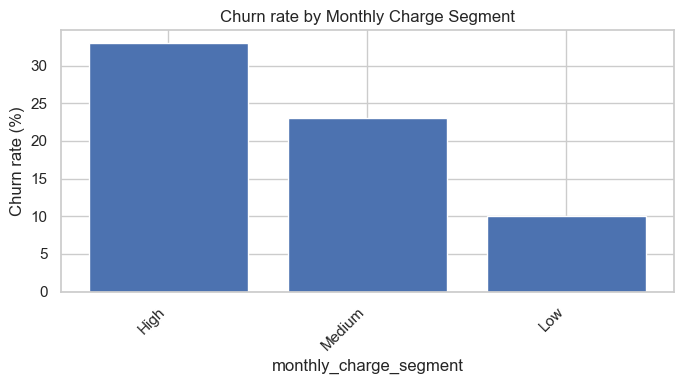

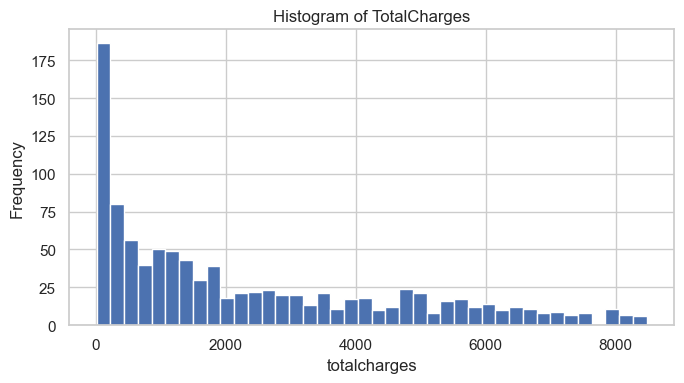

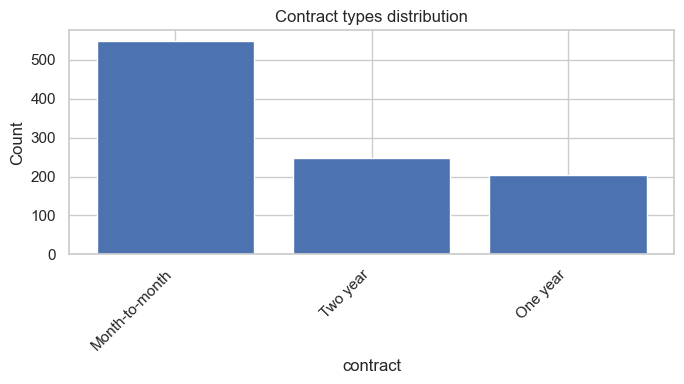

Plots saved to data\processed\plots


In [12]:
# Optional visualizations: create and save plots
if 'monthly_charge_segment' in df.columns and churn_flag_col in df.columns:
    seg = df[['monthly_charge_segment', churn_flag_col]].dropna()
    segg = seg.groupby('monthly_charge_segment')[churn_flag_col].mean().reset_index().sort_values(churn_flag_col, ascending=False)
    plt.figure(figsize=(7,4))
    plt.bar(segg['monthly_charge_segment'].astype(str), segg[churn_flag_col]*100)
    plt.ylabel('Churn rate (%)')
    plt.xlabel('monthly_charge_segment')
    plt.title('Churn rate by Monthly Charge Segment')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'churn_rate_by_monthly_charge_segment.png')
    plt.show()

if tc_col in df.columns:
    plt.figure(figsize=(7,4))
    df[tc_col].dropna().plot(kind='hist', bins=40)
    plt.xlabel(tc_col)
    plt.title('Histogram of TotalCharges')
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'hist_total_charges.png')
    plt.show()

if contract_col in df.columns:
    plt.figure(figsize=(7,4))
    counts = df[contract_col].fillna('UNKNOWN').astype(str).value_counts()
    plt.bar(counts.index.astype(str), counts.values)
    plt.ylabel('Count')
    plt.xlabel(contract_col)
    plt.title('Contract types distribution')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'contract_types_bar.png')
    plt.show()

print('Plots saved to', PLOTS_DIR)
